In [2]:
import pymc3 as pm
import graphviz
import arviz as az
az.style.use('seaborn')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/kz/3m7b5b5n7n19qtpq86vft4ww0000gn/T/ipykernel_51564/1928505931.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  az.style.use('seaborn')


### Generate data

In [3]:
num_samples = 5_000

# Generate random numbers from a uniform distribution over the interval [0, 1)
random_numbers = np.random.rand(num_samples)
default_rates = random_numbers*0.1


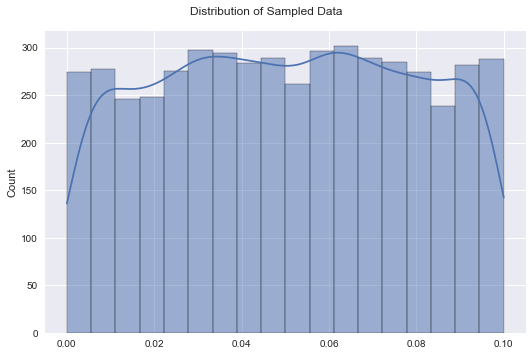

In [4]:
sample_distribution = sns.displot(
    data = default_rates,
    kde = True,
    aspect = 1.5
)

sample_distribution.fig.suptitle('Distribution of Sampled Data')

plt.tight_layout();

### Specify model and *"push inference button"*

In [5]:
# Prior parameters
n_SMEs = 1_000
prob = 0.03

In [6]:
# Model definition
with pm.Model() as default_rate_model:
    # Prior for the default rate
    default_rate = pm.Beta('default_rate', alpha = 1, beta = 1)
    
    # Likelihood of the observed data
    defaults = pm.Gamma('defaults', alpha=default_rate * n_SMEs, beta=n_SMEs, observed=default_rates)
    
    # MCMC sampling
    trace = pm.sample(5_000, tune=2_500)

/var/folders/kz/3m7b5b5n7n19qtpq86vft4ww0000gn/T/ipykernel_51564/1181294783.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5_000, tune=2_500)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [default_rate]


/Users/carlospumar/opt/anaconda3/envs/credit_risk/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/carlospumar/opt/anaconda3/envs/credit_risk/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/carlospumar/opt/anaconda3/envs/credit_risk/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8884291759082383, but should be close to 0.8. Try to increase the number of tuning steps.


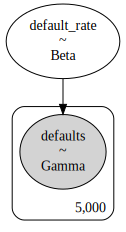

In [7]:
# plot causal relationships in model
pm.model_to_graphviz(default_rate_model)

### Check posterior predictive

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/carlospumar/opt/anaconda3/envs/credit_risk/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


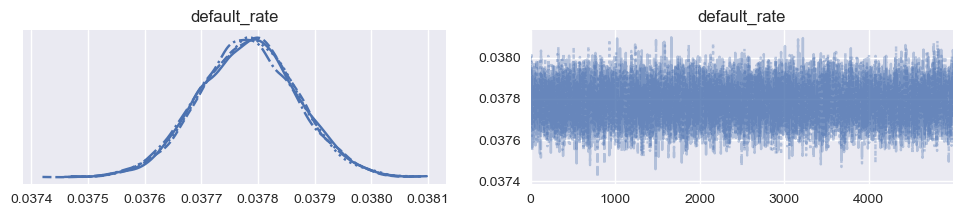

In [8]:
az.plot_trace(trace);

* stationarity (good! we need this for the `MCMC` simulation to converge...)
* note 4 chains (essentially all lying on top of each other, LHS-plot)

### Summarize posterior

In [9]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/carlospumar/opt/anaconda3/envs/credit_risk/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
default_rate,0.038,0.0,0.038,0.038,0.0,0.0,9315.0,13200.0,1.0


* see mean value for `default_rate` sampled from posterior distribution (3.7%)
* see value for `r_hat`: the closer it is to `1`, the more the model converges

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/carlospumar/opt/anaconda3/envs/credit_risk/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


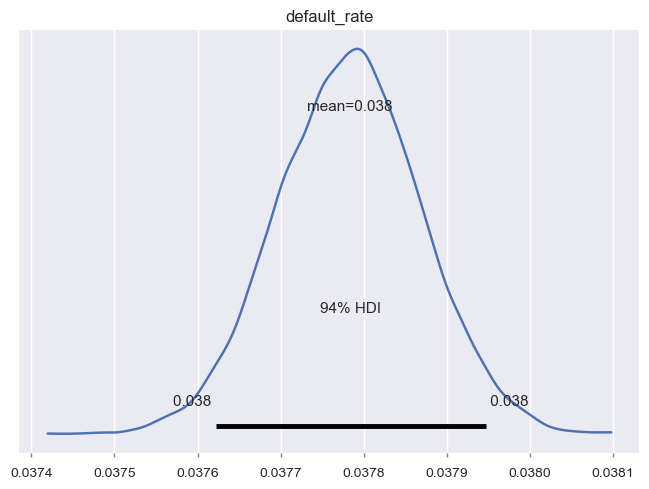

In [10]:
# Posterior analysis
az.plot_posterior(trace, var_names=['default_rate']);

* this is **bayesian**: we get a *distribution* for default rates (indicating our uncertainty around its mean value - as opposed to a (long-term) expected value for it)

In [11]:
with default_rate_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

In [13]:
# Create an InferenceData object using the posterior predictive samples
data = az.from_pymc3(trace=trace, posterior_predictive=posterior_predictive)

Got error No model on context stack. trying to find log_likelihood in translation.


Text(0.5, 1.0, 'Posterior Predictive Check')

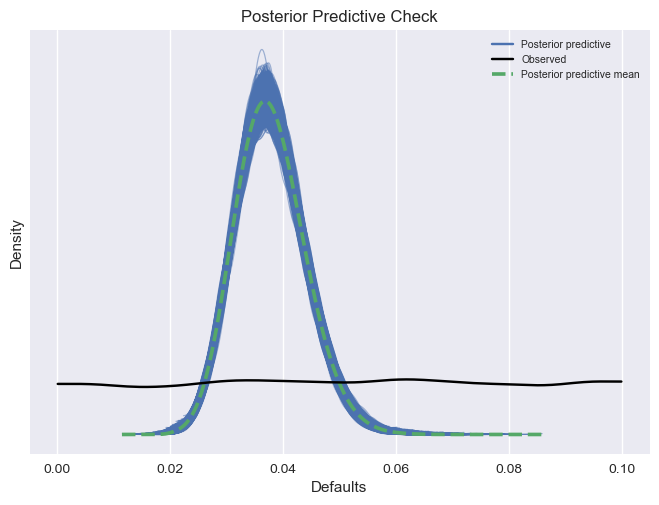

In [14]:
# Plotting posterior distribution vs real distribution using ArviZ
az.plot_ppc(data, var_names=['defaults'], alpha=0.5)

# Customize the plot
plt.xlabel('Defaults')
plt.ylabel('Density')
plt.title('Posterior Predictive Check')

### TODO
* use `lognormal`for `DGP`
* predict